In [1]:
import numpy
import matplotlib.pyplot as plt

from utils.dataset import load_project_dataset
from utils.dataset import split_db_2to1
import utils.helpers as helpers

In [27]:
D, L = load_project_dataset()
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L, seed=0)

In [28]:
print(DTR.shape, LTR.shape)
print(DVAL.shape, LVAL.shape)

(6, 4000) (4000,)
(6, 2000) (2000,)


In [33]:
m = 6
UPCA = helpers.compute_pca(DTR, m = m)
DTR_pca = helpers.apply_pca(UPCA, DTR)
DVAL_pca = helpers.apply_pca(UPCA, DVAL) # Applied to original validation data

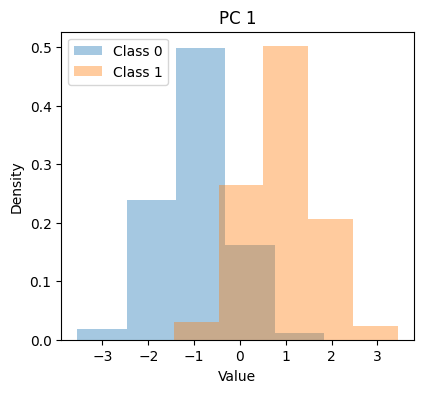

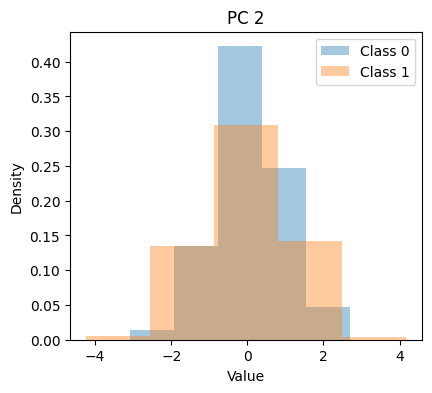

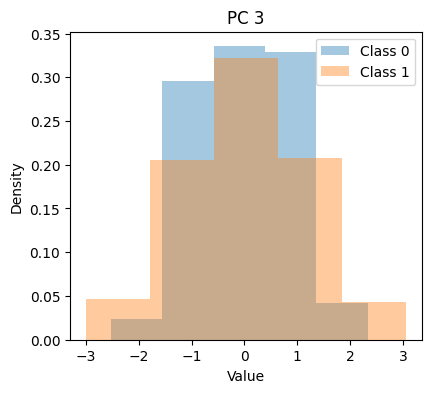

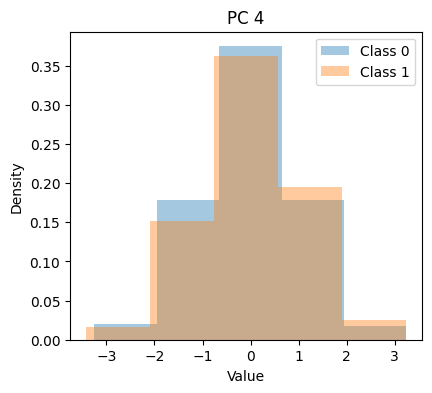

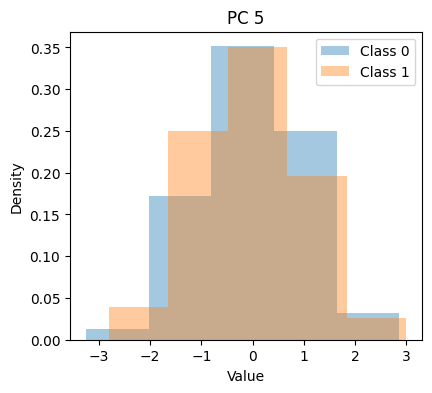

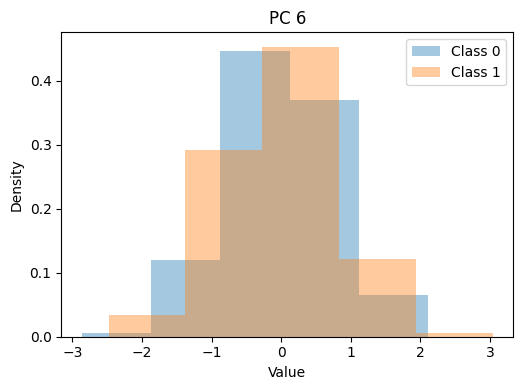

In [34]:
# --- Training set ---
for i in range(m):
    plt.figure(figsize=(10, 4))
    for label in [0, 1]:
        plt.subplot(1, 2, 1)
        plt.hist(DTR_pca[i, LTR == label], bins=5, alpha=0.4, density=True, label=f"Class {label}")
        plt.title(f"PC {i + 1}")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()

In [35]:
ULDA = helpers.compute_lda_JointDiag(DTR_pca, LTR, m = 1) # Estimated only on model training data, after PCA has been applied

DTR_lda = helpers.apply_lda(ULDA, DTR_pca)   # Applied to PCA-transformed model training data, the projected training samples are required to check the orientation of the direction and to compute the threshold
# Check if the Virginica class samples are, on average, on the right of the Versicolor samples on the training set. If not, we reverse ULDA and re-apply the transformation
if DTR_lda[0, LTR==0].mean() > DTR_lda[0, LTR==1].mean():
    ULDA = -ULDA
    DTR_lda = helpers.apply_lda(ULDA, DTR_pca)

DVAL_lda = helpers.apply_lda(ULDA, DVAL_pca) # Applied to PCA-transformed validation data

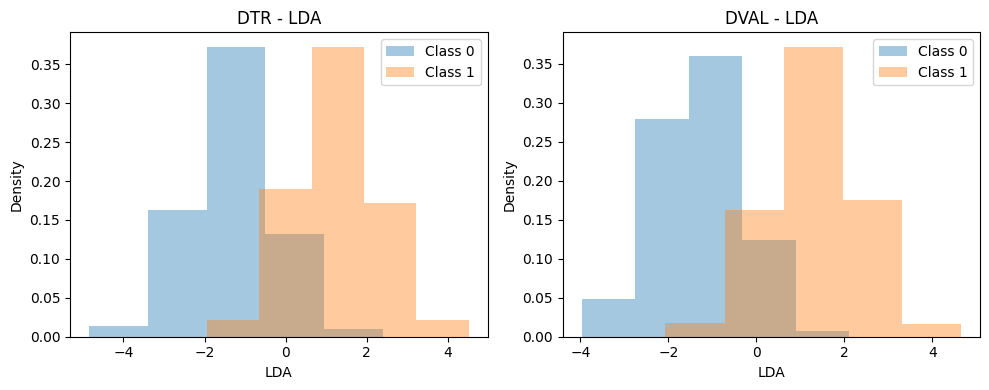

In [38]:
plt.figure(figsize=(10, 4))

# --- Training set ---
plt.subplot(1, 2, 1)
for label in [0, 1]:
    plt.hist(DTR_lda[0, LTR == label], bins=5, alpha=0.4, density=True, label=f"Class {label}")
plt.title("DTR - LDA")
plt.xlabel("LDA")
plt.ylabel("Density")
plt.legend()

# --- Validation set ---
plt.subplot(1, 2, 2)
for label in [0, 1]:
    plt.hist(DVAL_lda[0, LVAL == label], bins=5, alpha=0.4, density=True, label=f"Class {label}")
plt.title("DVAL - LDA")
plt.xlabel("LDA")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
threshold = (DTR_lda[0, LTR==0].mean() + DTR_lda[0, LTR==1].mean()) / 2.0 # Estimated only on model training data
print(threshold)

-0.018534376786207174


In [41]:
PVAL = numpy.zeros(shape=LVAL.shape, dtype=numpy.int32)
PVAL[DVAL_lda[0] >= threshold] = 1
PVAL[DVAL_lda[0] < threshold] = 0
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.1f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))

Labels:      [0 0 1 ... 0 0 0]
Predictions: [0 0 1 ... 0 0 0]
Number of erros: 186 (out of 2000 samples)
Error rate: 9.3%
